# Whatsapp Group Chat Data Analysis

[github fork](https://github.com/Tariqueakhtar/Machine-Learning/tree/master/whatsapp%20chat%20analysis)

## 1. Data Sourcing

### 1.1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from plotly import express as px

import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiments = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


### 1.2. Load Whatsapp Group Chat Data

In [3]:
filepath = 'chat-otakus.txt'
df = pd.read_csv(filepath, sep = "delimiter",skip_blank_lines = True, header = None)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [4]:
df

,0
0,"[10/04/21, 2:24:23 a.m.] オタクゲーマー: ‎Los mensaje..."
1,"[10/04/21, 2:24:23 a.m.] ‎Creaste este grupo"
2,"[31/10/21, 11:40:35 p.m.] Roberto: Rolen stick..."
3,"[31/10/21, 11:40:43 p.m.] Roberto: Se me borró..."
4,"‎[31/10/21, 11:41:21 p.m.] Diego Braña: ‎stick..."
...,...
44686,‎OPCIÓN: No (0 votos)
44687,"‎OPCIÓN: Si, más no tanto como el zuki (3 votos)"
44688,"‎[14/12/22, 3:44:27 p.m.] Pekiz: ‎sticker omitido"
44689,"[14/12/22, 3:45:48 p.m.] Zuki: Cambia tu voto ..."


## 2. Data Preperation

### 2.1 Extract functions

In [5]:
# Extract date values and return as list of string
def getdate(x):
    res = re.search("\d\d/\d\d/\d\d",x)
    if res != None:
        return res.group()
    else:
        return ""


# Extract time stamp from chat data and store in new column Time and Am
def gettime(x):
    res = re.search("\d+:\d\d:\d\d\s[a||p].m.", x)
    if res != None:
        return res.group()
    else:
        return ""


# Extract sender
def getsender(x):
  res = re.search(re.compile(" .*?: "),x)
  if res !=None:
      return res.group()[1:-2]
  else:
      return ""


# Extract final message from chat data
def getmessage(x):
    res = re.search(": .*",x)
    if res != None:
        return res.group()[2:]
    else:
        return None

In [6]:
df["Date"] = list(map(lambda x : getdate(x), df.iloc[:,0]))

# Merge multiline chat data
for i in range(0,len(df)):
    if df["Date"][i] == "":
        c=i-1
        for j in range(i,len(df)):
            if df["Date"][j] == "":
                df.iloc[c,0] = " ".join([df.iloc[c,0],df.iloc[j,0]])
                    
            else:
                i=j-1
                break
    else:
        df.iloc[i,0] = df.iloc[i,0]

In [7]:
## Remove rows where date is empty
df.drop(np.where(df.iloc[:,1]=="")[0],inplace =True)
## Reindex the dataframe
df.index = range(0,len(df))


##Remove date from original text data using substitute function of regular expression
df.iloc[:,0] = list(map(lambda x : re.sub("../../..","", x)[2:],df.iloc[:,0]))


## Extract Day Month and Year from Date 
df["Day"] = list(map(lambda d : d.split("/")[0], df.Date))
df["Months"] = list(map(lambda d : d.split("/")[1], df.Date))
df["Year"] = list(map(lambda d : d.split("/")[2], df.Date))


Timestamp = list(map(lambda x : gettime(x),df.iloc[:,0])) 

df["Time"] = list(map(lambda t : t.split(" ")[0],Timestamp))
df["Hour"] = list(map(int,list(map(lambda t : t.split(":")[0],df["Time"]))))
df["Minute"] = list(map(int,list(map(lambda t : t.split(":")[1],df["Time"]))))
df["AmPm"] = list(map(lambda t : t.split(" ")[1],Timestamp))


## Remove Timestamps from chat
df.iloc[:,0] = list(map(lambda x : re.sub("[\d||\d\d]:\d\d:\d\d\s[a||p].m.","", x)[2:],df.iloc[:,0]))
    
    
df["sender"] =list(map(getsender,df.iloc[:,0]))


## Drop rows of activity messages - member added/removed/left/group name change/icon change/others
df.drop((np.where(df["sender"]=="")[0]),inplace = True)
## Reindex the dataframe
df.index = range(0,len(df))


df["Message"] = list(map(getmessage,df.iloc[:,0]))


## Drop column 0
df = df.drop(0,axis =1)

<ipython-input-5-2420d8af1588>:12: FutureWarning: Possible set union at position 17
  res = re.search("\d+:\d\d:\d\d\s[a||p].m.", x)
<ipython-input-7-e8d50d8c14ca>:26: FutureWarning: Possible set union at position 3
  df.iloc[:,0] = list(map(lambda x : re.sub("[\d||\d\d]:\d\d:\d\d\s[a||p].m.","", x)[2:],df.iloc[:,0]))
<ipython-input-7-e8d50d8c14ca>:26: FutureWarning: Possible set union at position 24
  df.iloc[:,0] = list(map(lambda x : re.sub("[\d||\d\d]:\d\d:\d\d\s[a||p].m.","", x)[2:],df.iloc[:,0]))


## 3. Data Exploration

In [8]:
df.head()

,Date,Day,Months,Year,Time,Hour,Minute,AmPm,sender,Message
0,10/04/21,10,04,21,2:24:23,2,24,a.m.,オタクゲーマー,‎Los mensajes y las llamadas están cifrados de...
1,31/10/21,31,10,21,11:40:35,11,40,p.m.,Roberto,Rolen stickers banda
2,31/10/21,31,10,21,11:40:43,11,40,p.m.,Roberto,Se me borró todo del cel
3,31/10/21,31,10,21,11:41:21,11,41,p.m.,Diego Braña,‎sticker omitido
4,31/10/21,31,10,21,11:41:39,11,41,p.m.,Roberto,Jajjajajajaj


In [9]:
# Find unique members in group
group_members = list(set(df["sender"]))

# Find count of messages shared by each member
n_message = list(map(lambda x : len(np.where(df["sender"]==x)[0]),group_members)) 

# Create a dataframe to store above values
activity_data = pd.DataFrame({"sender": group_members,"n_count":n_message})

# Sort data for convenience and rearrange index
activity_data = activity_data.sort_values(by=["n_count"], ascending=False)
activity_data.index = range(0,len(activity_data))

# creating groups of data by time meridian
timemeridian = df.groupby(by = "AmPm")

amhours = timemeridian.get_group("a.m.")
pmhours = timemeridian.get_group("p.m.")

# getting hourly activity counts
amhourcounts = amhours.Hour.value_counts().sort_index()
pmhourcounts = pmhours.Hour.value_counts().sort_index()

In [29]:
activity_data

,sender,n_count
0,Roberto,9763
1,Daniel Saldaña,7264
2,Zuki,5033
3,Diego Braña,4848
4,Jimbo,4219
5,Neto,4127
6,SuperDog,2750
7,‪+52 899 497 4078‬,2151
8,Pekiz,1861
9,Clayton,1311


### 3.1 Top Active Members

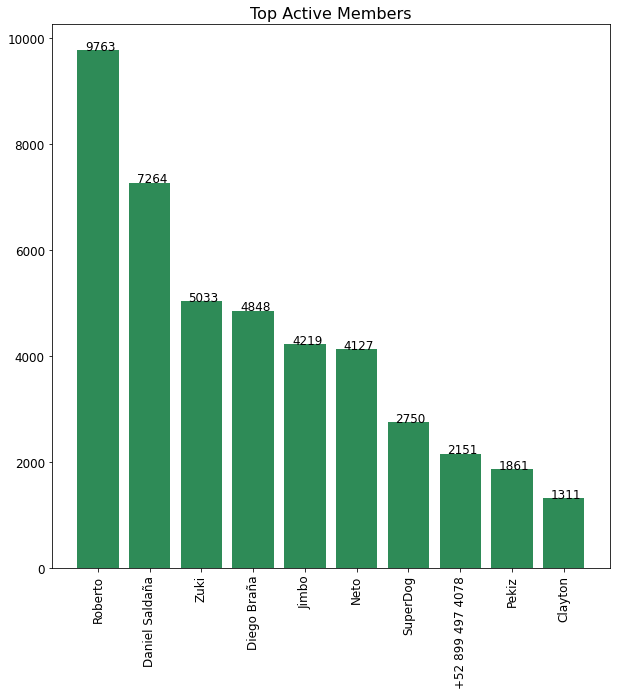

In [28]:
# Most active members in group
members = activity_data.shape[0]

X = activity_data["sender"][:members]
Y = activity_data.n_count[:members]

plt.figure(figsize=[10,10])

plt.title("Top Active Members", size = 16)

plt.bar(x = X, height= Y, color = "seagreen")
plt.xticks(rotation = 90, size = 12)
plt.yticks(size = 12)

for i in range(0,members):
    plt.annotate(s = Y[i], xy = (i-0.25,Y[i]+5), size = 12)

plt.show()


In [12]:
z = df['Date'].value_counts() 
z1 = z.to_dict() 
df['Msg_count'] = df['Date'].map(z1)

# Timeseries plot 
fig = px.line(x=df['Date'],y=df['Msg_count'])
fig.update_layout(title='Analysis of number of messages using TimeSeries plot.',
                  xaxis_title='Month',
                  yaxis_title='No. of Messages')
fig.update_xaxes(nticks=20)
fig.show()

### 3.2 Activity Throughout Day

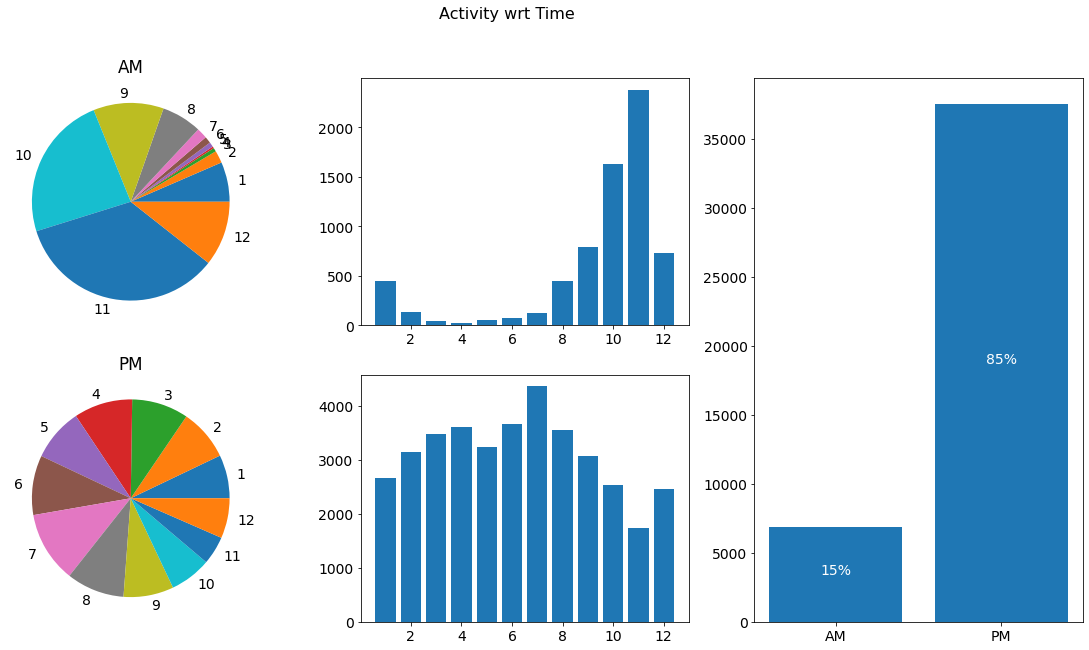

In [13]:
fig = plt.figure(figsize=[20,10])
mpl.rcParams['font.size'] = 14.0

fig.suptitle("Activity wrt Time", size = 16)

gs = GridSpec(2,3) # 2 rows and 3 columns
ax1 = fig.add_subplot(gs[0,0]) # first row, first col
ax2 = fig.add_subplot(gs[0,1]) # first row, second col
ax3 = fig.add_subplot(gs[1,0]) # second row, first col
ax4 = fig.add_subplot(gs[1,1]) # second row, second col
ax5 = fig.add_subplot(gs[:,2]) # all row, third col

# Pie plot for messages shared in AM time meridian
ax1.pie(amhourcounts.values, labels = amhourcounts.index)
ax1.set_title("AM")
# Bar plot for messages shared in AM time meridian
ax2.bar(amhourcounts.index,amhourcounts.values)

# Pie plot for messages shared in PM time meridian
ax3.pie(pmhourcounts.values, labels = pmhourcounts.index)
ax3.set_title("PM")
# Bar plot for messages shared in PM time meridian
ax4.bar(pmhourcounts.index,pmhourcounts.values)

# Bar plot showing AM vs PM
ax5.bar(["AM","PM"], [len(amhours),len(pmhours)])
ax5.annotate(s = str(round(100*len(amhours)/(len(amhours)+len(pmhours)))) + "%", xy = [0,len(amhours)/2], color = "white", size = 14, horizontalalignment = "center")
ax5.annotate(s = str(round(100*len(pmhours)/(len(amhours)+len(pmhours)))) + "%", xy = [1,len(pmhours)/2], color = "white", size = 14, horizontalalignment = "center")


plt.show()

In [14]:
df["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in df["Message"]]
df["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in df["Message"]]
df["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in df["Message"]]

In [15]:
df

,Date,Day,Months,Year,Time,Hour,Minute,AmPm,sender,Message,Msg_count,Positive,Negative,Neutral
0,10/04/21,10,04,21,2:24:23,2,24,a.m.,オタクゲーマー,‎Los mensajes y las llamadas están cifrados de...,1,0.0,0.000,1.000
1,31/10/21,31,10,21,11:40:35,11,40,p.m.,Roberto,Rolen stickers banda,23,0.0,0.000,1.000
2,31/10/21,31,10,21,11:40:43,11,40,p.m.,Roberto,Se me borró todo del cel,23,0.0,0.000,1.000
3,31/10/21,31,10,21,11:41:21,11,41,p.m.,Diego Braña,‎sticker omitido,23,0.0,0.000,1.000
4,31/10/21,31,10,21,11:41:39,11,41,p.m.,Roberto,Jajjajajajaj,23,0.0,0.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44364,14/12/22,14,12,22,3:33:54,3,33,p.m.,Neto,JAJAJAJAJA,207,0.0,0.000,1.000
44365,14/12/22,14,12,22,3:44:20,3,44,p.m.,Pekiz,‎ENCUESTA: Dosan es simp. si o no ‎OPCIÓN: Si ...,207,0.0,0.239,0.761
44366,14/12/22,14,12,22,3:44:27,3,44,p.m.,Pekiz,‎sticker omitido,207,0.0,0.000,1.000
44367,14/12/22,14,12,22,3:45:48,3,45,p.m.,Zuki,Cambia tu voto @5219933065910,207,0.0,0.000,1.000


In [16]:
x = sum(df["Positive"])
y = sum(df["Negative"])
z = sum(df["Neutral"])

def sentiment_score(a, b, c):
    if (a>b) and (a>c):
        print("Positive 😊 ")
    elif (b>a) and (b>c):
        print("Negative 😠 ")
    else:
        print("Neutral 🙂 ")
sentiment_score(x, y, z)

Neutral 🙂 


In [17]:
print(x,y,z)

1375.0040000000029 1767.9720000000086 40869.01000000008


In [18]:
#df.to_csv('output.csv', encoding='utf-8')